<a href="https://colab.research.google.com/github/alehb80/skin-lesion-classification/blob/master/skin_lesion_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SKIN LESION CLASSIFICATION

## 1. Introduction

### Import API Kaggle

In [0]:
!pip install -q kaggle

In [0]:
!mkdir  ~/.kaggle
!touch ~/.kaggle/kaggle-5.json

api_token = {"username":"gianlucavisentin","key":"c609dca13d58751e6fc9d489a0dddb2d"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=8108b582594922f5c1aa538ccbaf6e1875f9cf383dfceb8cf075245a74bc957d
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


### Search the dataset on Kaggle

In [4]:
!kaggle datasets list -s skin

ref                                                    title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
kmader/skin-cancer-mnist-ham10000                      Skin Cancer MNIST: HAM10000                      5GB  2018-09-20 20:36:13          23508        715  0.7058824        
fanconic/skin-cancer-malignant-vs-benign               Skin Cancer: Malignant vs. Benign              325MB  2019-06-19 21:51:11           3026         74  0.75             
nodoubttome/skin-cancer9-classesisic                   Skin Cancer ISIC                                 2GB  2019-08-26 18:59:21            637         15  0.75             
tsaideepak/skin-cancer                                 skin cancer                                    462MB  2019-03-23 19:39:19  

### Download the dataset

In [5]:
# Copy the dataset locally
!kaggle datasets download --force -d kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [01:49<00:00, 102MB/s] 
100% 5.20G/5.20G [01:49<00:00, 50.9MB/s]


In [6]:
!unzip skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: ham10000_images_part_2/ISIC_0029342.jpg  
  inflating: h

### Import all libraries

In [7]:
# Matrix and dataframe manipulation
import numpy as np
import pandas as pd

# Image operations and plotting
from PIL import Image
from skimage.io import imread, imshow
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
%matplotlib inline

# File, path and directory operations
import os
from glob import glob

# Data augmentation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Model building
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

# Data preparation
from sklearn.model_selection import train_test_split

# For aesthetics
import warnings
warnings.filterwarnings('ignore')

# Others
from keras.utils.np_utils import to_categorical

# from keras.models import Sequential
# from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## 2. Data Analysis And Preprocessing

### Build dataframe

In [0]:
# merge the images in jpg format from both the folders
base_skin_dir = "./"
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [9]:
tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(6)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
566,HAM_0001944,ISIC_0029810,bkl,histo,55.0,female,ear,./ham10000_images_part_2/ISIC_0029810.jpg,Benign keratosis-like lesions,2
3804,HAM_0001035,ISIC_0026129,nv,follow_up,60.0,male,lower extremity,./ham10000_images_part_1/ISIC_0026129.jpg,Melanocytic nevi,4
3783,HAM_0005013,ISIC_0030448,nv,follow_up,45.0,female,back,./ham10000_images_part_2/ISIC_0030448.jpg,Melanocytic nevi,4
4658,HAM_0000370,ISIC_0025998,nv,follow_up,70.0,male,trunk,./ham10000_images_part_1/ISIC_0025998.jpg,Melanocytic nevi,4
8072,HAM_0000348,ISIC_0028290,nv,histo,35.0,male,back,./ham10000_images_part_1/ISIC_0028290.jpg,Melanocytic nevi,4
1526,HAM_0003386,ISIC_0033452,mel,histo,70.0,male,abdomen,./ham10000_images_part_2/ISIC_0033452.jpg,Melanoma,5


### Plot the distribution

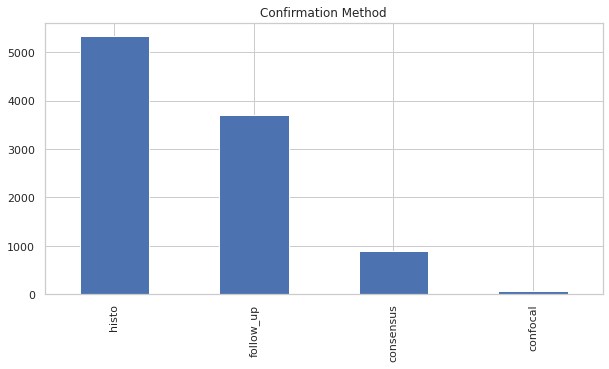

In [10]:
# Plot the distibution of groud truth confirmation method
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
tile_df['dx_type'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Confirmation Method');

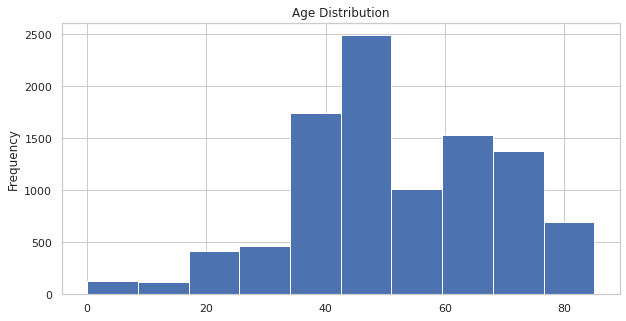

In [11]:
# Plot the age distribution
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
tile_df['age'].plot(kind='hist', ax=ax1)
ax1.set_title('Age Distribution');

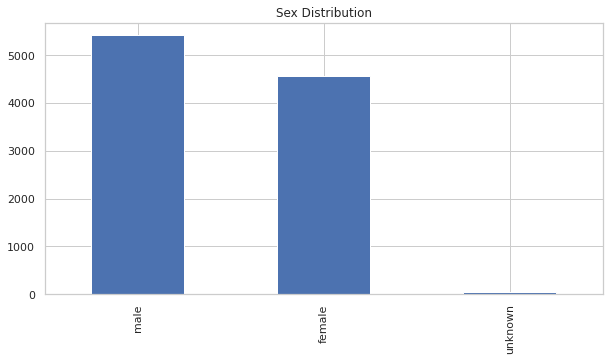

In [12]:
# Plot the sex distibution
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
tile_df['sex'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Sex Distribution');

In [13]:
# Since we are not going to use the meta data in our final model, let's just replace 'unknown' 
# values with 'male'. We could consider dropping these if we were going to use the metadata
tile_df['sex'].replace(to_replace='unknown', value='male', inplace=True)
tile_df['sex'].value_counts()

male      5463
female    4552
Name: sex, dtype: int64

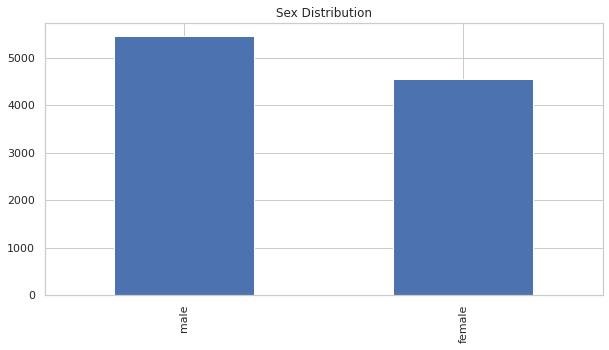

In [14]:
# Plot the sex distibution
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
tile_df['sex'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Sex Distribution');

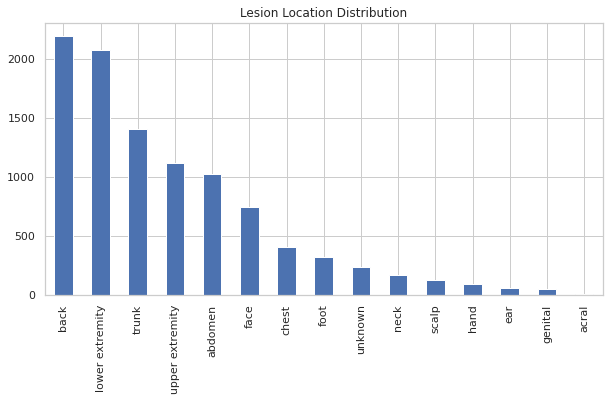

In [15]:
# Plot the distibution of lesion location
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
tile_df['localization'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Lesion Location Distribution');

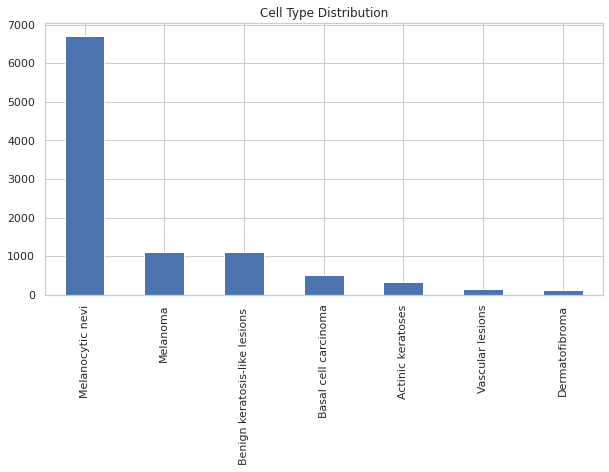

In [16]:
# Plot the distibution of cell types represented in the dataset
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Cell Type Distribution');

### Cleaning data

In [17]:
# show if there is a null data
tile_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [18]:
# calculate te mean value of the "age" feature
print(tile_df['age'].mean())

51.863828077927295


In [0]:
# fill the null values by their mean
tile_df['age'].fillna((tile_df['age'].mean()), inplace=True)

In [20]:
# show if there is a null data
tile_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

### Drop duplicates images

In [21]:
# this will tell us how many images are associated with each lesion_id
df_undup = tile_df.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [22]:
# here we identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
tile_df['duplicates'] = tile_df['lesion_id']
# apply the function to this new column
tile_df['duplicates'] = tile_df['duplicates'].apply(get_duplicates)
tile_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./ham10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,duplicated


In [23]:
tile_df['duplicates'].value_counts()

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64

In [24]:
# now we filter out images that don't have duplicates
df_undup = tile_df[tile_df['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 11)

In [25]:
# now we create a val set using df because we are sure that none of these images have augmented duplicates in the train set
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1103, 11)

In [26]:
df_val['cell_type_idx'].value_counts()

4    883
2     88
5     46
1     35
0     30
6     13
3      8
Name: cell_type_idx, dtype: int64

In [27]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows
# create a new colum that is a copy of the image_id column
tile_df['train_or_val'] = tile_df['image_id']
# apply the function to this new column
tile_df['train_or_val'] = tile_df['train_or_val'].apply(get_val_rows)
# filter out train rows
df_train = tile_df[tile_df['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))

8912
1103


In [28]:
df_train['cell_type_idx'].value_counts()

4    5822
5    1067
2    1011
1     479
0     297
6     129
3     107
Name: cell_type_idx, dtype: int64

In [29]:
df_val['cell_type'].value_counts()

Melanocytic nevi                  883
Benign keratosis-like lesions      88
Melanoma                           46
Basal cell carcinoma               35
Actinic keratoses                  30
Vascular lesions                   13
Dermatofibroma                      8
Name: cell_type, dtype: int64

### Equalization sampling //TODO

// TODO: da rivedere: https://www.kaggle.com/xinruizhuang/skin-lesion-classification-acc-90-pytorch

*From From the above statistics of each category, we can see that there is a serious class imbalance in the training data. To solve this problem, I think we can start from two aspects, one is equalization sampling, and the other is a loss function that can be used to mitigate category imbalance during training, such as focal loss.*

In [30]:
# Copy fewer class to balance the number of 7 classes
data_aug_rate = [15,10,5,50,0,40,5]
for i in range(7):
    if data_aug_rate[i]:
        df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
df_train['cell_type'].value_counts()

Melanoma                          42680
Melanocytic nevi                   5822
Dermatofibroma                     5350
Benign keratosis-like lesions      5055
Basal cell carcinoma               4790
Actinic keratoses                  4455
Vascular lesions                    645
Name: cell_type, dtype: int64

### View image samples

In [0]:
# show some image samples
# n_samples = 5
# fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
# for n_axs, (type_name, type_rows) in zip(m_axs, 
#                                          tile_df.sort_values(['cell_type']).groupby('cell_type')):
#     n_axs[0].set_title(type_name)
#     for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
#         c_ax.imshow(c_row['image'])
#         c_ax.axis('off')
# fig.savefig('category_samples.png', dpi=300)

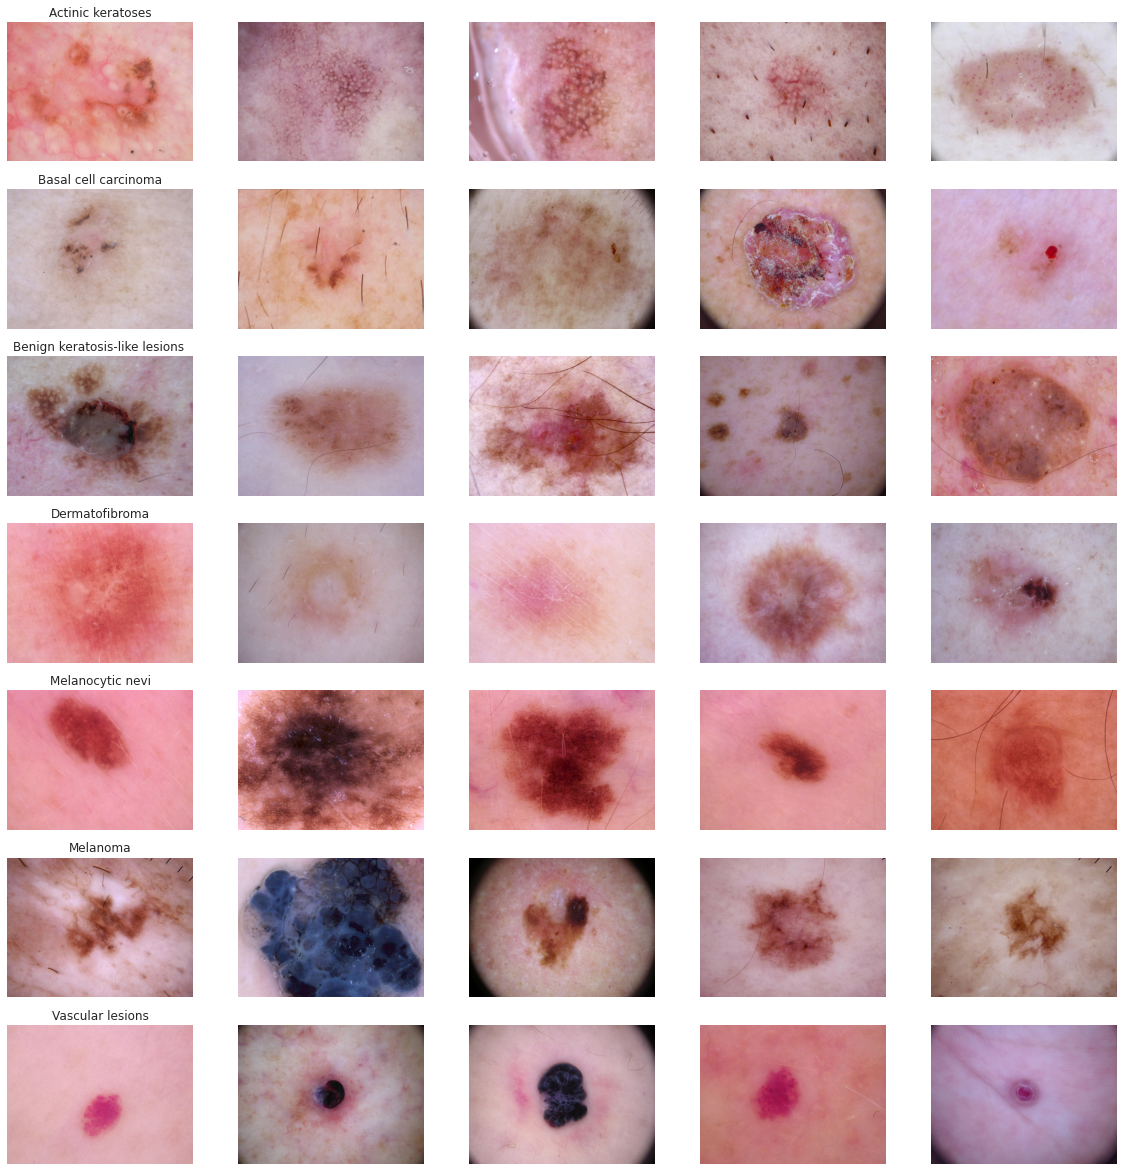

In [32]:
# Display 5 examples of each cell type
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=108).iterrows()):
        c_ax.imshow(imread(c_row['path']))
        c_ax.axis('off')

### Loading and resize images

In [0]:
# resize the images to 100 * 75 which tensorflow can handle
tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [34]:
# checking the image size distribution
tile_df['image'].map(lambda x: x.shape)

0        (75, 100, 3)
1        (75, 100, 3)
2        (75, 100, 3)
3        (75, 100, 3)
4        (75, 100, 3)
             ...     
10010    (75, 100, 3)
10011    (75, 100, 3)
10012    (75, 100, 3)
10013    (75, 100, 3)
10014    (75, 100, 3)
Name: image, Length: 10015, dtype: object

## 3. Build The Dataset

### Split data into train and test with 80:20 ratio

In [0]:
features=tile_df.drop(columns=['cell_type_idx'],axis=1)
target=tile_df['cell_type_idx']

# 'train_test_split' splits arrays or matrices into random train and test subsets
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

### Normalization

In [0]:
# subtract their mean values from it and then dividing by their standard deviation
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

### Label Encoding

In [0]:
# labels are 7 different classes of cell types from 0 to 6. We need to encode these lables to one hot vectors
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

### Training and Validation Split

In [0]:
# validate:train >> 10:90 %
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 2)

In [0]:
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

## 4. Model Building

### Define the deep convolutional network architecture

In [0]:
#input_shape = (75, 100, 3)
#num_classes = 7
#model = Sequential([
 #   Conv2D(32, 3, padding='same', activation='relu', input_shape=input_shape),
  #  Conv2D(32, 3, padding='same', activation='relu'),
   # MaxPooling2D(),
    #Dropout(0.25),

    #Conv2D(64, 3, padding='same', activation='relu', input_shape=input_shape),
    #Conv2D(64, 3, padding='same', activation='relu'),
    #MaxPooling2D(),
    #Dropout(0.4),
    
    #Conv2D(128, 3, padding='same', activation='relu'),
    #MaxPooling2D(),
    #Dropout(0.5),
    
   # Flatten(),
   # Dense(128, activation='relu'),
    #Dropout(0.5),
    
    #Dense(7, activation='softmax')
#])


# Our input feature map is 75x100x3: 75x100 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(75, 100, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu', padding='same')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and softmax activation
output = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model
model = Model(img_input, output)

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [0]:
#model.compile(optimizer='adam',
             # loss='binary_crossentropy',
             #metrics=['accuracy'])

In [0]:

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[accuracy])

In [0]:
def get_call_back():
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
  reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                          factor=0.5, 
                                           min_lr=0.00001)
  return[reduce_lr]

#reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                 #factor=0.2,
                                #patience=5,
                                 #  min_lr=0.001)


In [44]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75, 100, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 75, 100, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 12, 64)         0     

### Avoid the overfitting

In [0]:
# avoiding the overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False
        )  # randomly flip images
datagen.fit(x_train)

## 5. Train Model

### Training

In [46]:
epochs = 30 
batch_size = 10
history = model.fit(
    datagen.flow(x_train,y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_validate,y_validate),
    validation_steps=x_validate.shape[0] // batch_size
    ,callbacks=get_call_back()
)

Epoch 1/30
640/640 [==============================] - 12s 19ms/step - loss: 0.9723 - accuracy: 0.6702 - val_loss: 0.8853 - val_accuracy: 0.6725 - lr: 0.0010
Epoch 2/30
640/640 [==============================] - 12s 19ms/step - loss: 0.8572 - accuracy: 0.6926 - val_loss: 0.7791 - val_accuracy: 0.7168 - lr: 0.0010
Epoch 3/30
640/640 [==============================] - 12s 19ms/step - loss: 0.7991 - accuracy: 0.7106 - val_loss: 0.7757 - val_accuracy: 0.7137 - lr: 0.0010
Epoch 4/30
640/640 [==============================] - 12s 19ms/step - loss: 0.7601 - accuracy: 0.7190 - val_loss: 0.7314 - val_accuracy: 0.7449 - lr: 0.0010
Epoch 5/30
640/640 [==============================] - 12s 19ms/step - loss: 0.7387 - accuracy: 0.7287 - val_loss: 0.7138 - val_accuracy: 0.7330 - lr: 0.0010
Epoch 6/30
640/640 [==============================] - 12s 19ms/step - loss: 0.7169 - accuracy: 0.7357 - val_loss: 0.6818 - val_accuracy: 0.7536 - lr: 0.0010
Epoch 7/30
640/640 [==============================] - 12s 

## 6. Evaluate Model

### Accuracy

In [47]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

51/51 [==============================] - 0s 4ms/step - loss: 0.6694 - accuracy: 0.7735
Validation: accuracy = 0.773550  ;  loss_v = 0.669432
Test: accuracy = 0.780829  ;  loss = 0.673400


### Visualize Learning

In [0]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

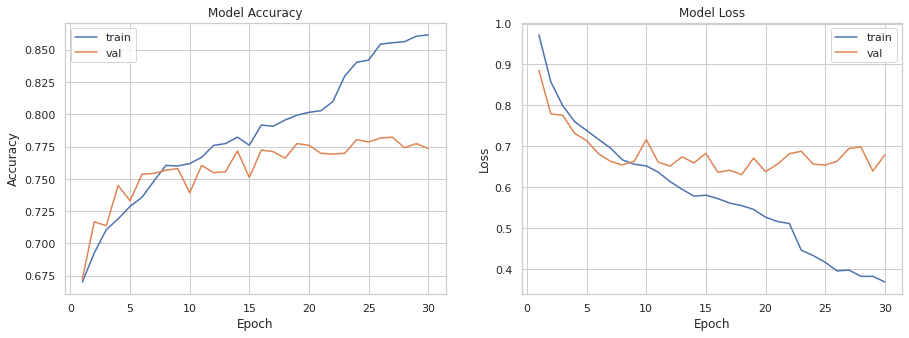

In [49]:
plot_model_history(history)